In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from util import *
from datetime import date

In [24]:
pth = './res'
model = 'exp003_fea'
obj = 'rb'
obj_list = ['SM',
 'au',
 'hc',
 'm',
#  'lh',
#  'cu',
#  'PF',
 'p',
#  'ZC',
#  'sp',
#  'i',
#  'jm',
#  'SF',
#  'jd',
#  'pg',
#  'ni',
#  'ag',
#  'RM',
#  'OI',
#  'CY',
#  'lu',
 'UR',
#  'CJ',
#  'cs',
 'sn',
 'j',
 'pb',
 'AP',
 'pp']
# dat = '20220623'
tick = pd.read_csv('symbol_instrumentid2.csv')
tick = tick[tick.pz==obj].tick.values[0]
chengshu = get_unit_cost(obj.lower())[1]*tick


In [25]:
start_date = date(2022, 1, 1)
end_date = date(2022, 6, 29)
dates = [n.strftime("%Y%m%d") for n in daterange(start_date, end_date)]
trades = []
feas = []
dd = pd.read_csv('symbol_instrumentid2.csv')
objs = obj_list
for obj in objs:
    for dat in dates:
        pth = os.path.join('./res', model, obj, dat)
        if os.path.exists(pth+'.csv'):
            trades.append(pd.read_csv(pth+'.csv'))
            pth = os.path.join('./feas', obj, dat)
            feas.append(pd.read_csv(pth+'.csv').iloc[:,1:])

trade_data = pd.concat(trades)
trade_data['drl'] = trade_data['drl']/chengshu
trade_data['pss'] = trade_data['pss']/chengshu
trade_data['agg'] = trade_data['agg']/chengshu
fea_data = pd.concat(feas)

data = pd.concat((trade_data, fea_data), axis=1)
data

,ticktime,drl,pss,agg,stepn,filled_seconds,volatility,vol_ratio,trend,trend.1,ema
0,09:26:50.000,0.0,0.0,2.0,159.0,63.000,3.795099,1.960768,50,50.0,0.009651
1,09:28:47.000,0.0,0.0,1.0,29.5,8.000,7.137051,1.914087,47,47.0,0.006319
2,09:30:33.000,0.0,0.0,2.0,58.5,115.000,5.644565,1.417193,44,44.0,0.004719
3,09:31:32.000,0.0,0.0,2.0,0.5,13.000,4.834770,1.526079,52,52.0,0.007730
4,09:32:33.000,0.0,0.0,1.0,0.5,1.000,6.279928,1.480892,49,49.0,0.007699
...,...,...,...,...,...,...,...,...,...,...,...
87,14:53:55.877,0.0,0.0,0.5,0.5,0.123,1.785357,0.750119,14,14.0,0.000586
88,14:54:50.381,0.0,0.0,1.0,7.0,6.619,1.414214,0.665699,13,13.0,0.000586
89,14:54:59.871,4.0,4.0,0.5,293.5,269.129,1.391941,0.721567,13,13.0,0.000586
90,14:56:26.744,0.0,0.0,0.5,2.0,1.256,1.394433,0.967145,18,18.0,0.000703


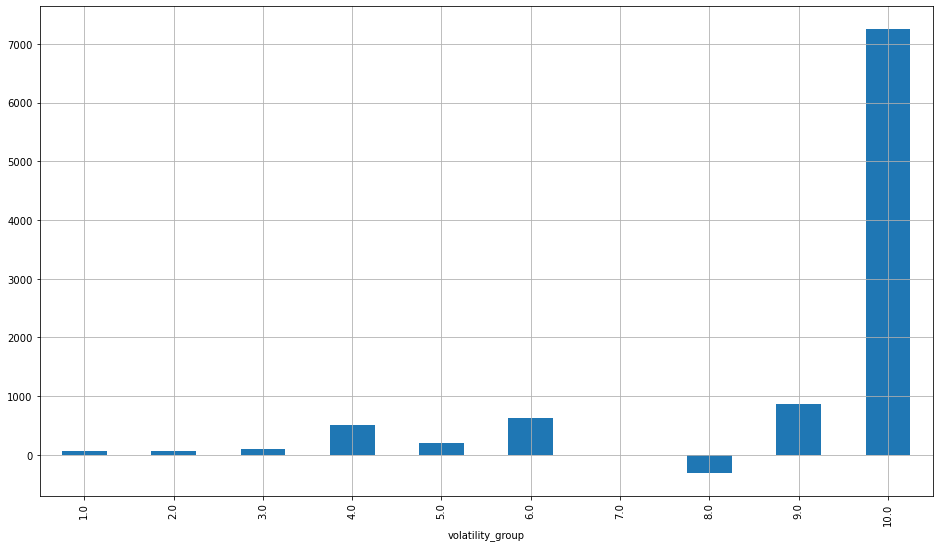

<AxesSubplot:xlabel='volatility_group'>

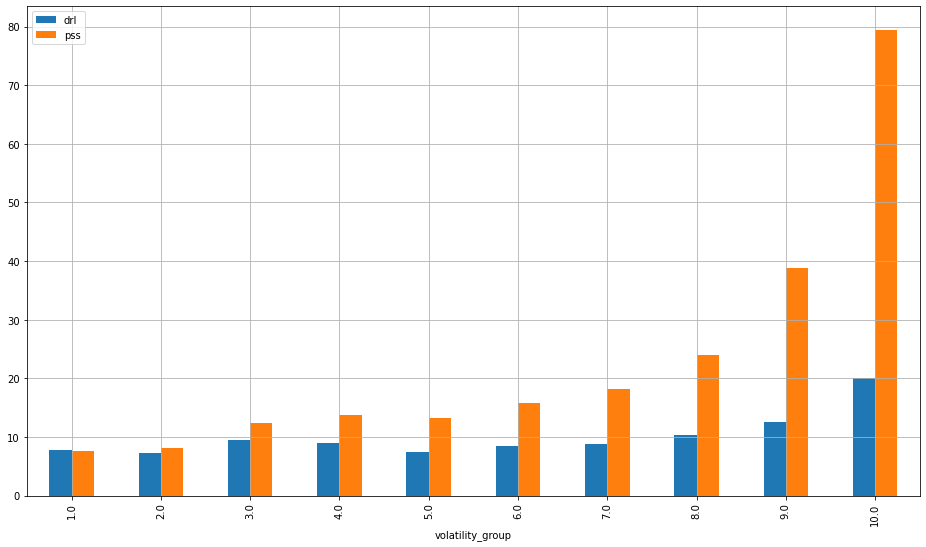

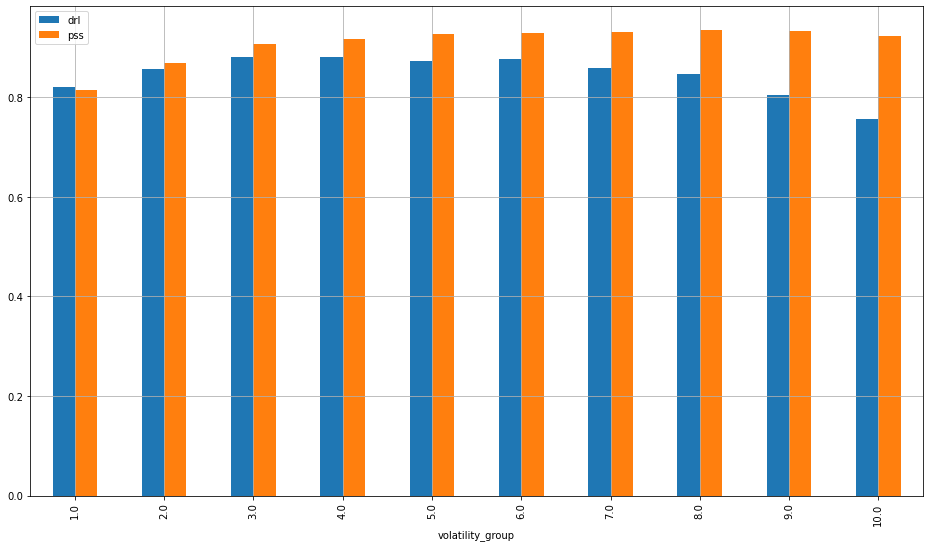

In [26]:
data.loc[:, 'vol_ratio_group'] = getStdFactor(data.vol_ratio, cuts=10)
data.loc[:, 'trend_group'] = getStdFactor(data.trend, cuts=10)
data.loc[:, 'volatility_group'] = getStdFactor(data.volatility, cuts=10)
data.loc[:, 'ema_group'] = getStdFactor(data.ema, cuts=10)
def Cal_WinRate(xdf):
    eps = 0.001
    winrate = len(xdf[xdf<=eps])*1.0/len(xdf)

    return winrate

def Cal_LossRatio(xdf):
    eps = 0.001
    lossratio = xdf[xdf>eps].mean()

    return lossratio

group = 'volatility_group'
winratedf = data.groupby(group).agg({'drl':Cal_WinRate, 'pss':Cal_WinRate})
lossratiodf = data.groupby(group).agg({'drl':Cal_LossRatio, 'pss':Cal_LossRatio})
sumcostdf = data.groupby(group).agg({'drl':'sum', 'pss':'sum'})

# lossratiodf = lossratiodf.pss-lossratiodf.drl
sumcostdf = sumcostdf.pss-sumcostdf.drl

sumcostdf.plot(kind='bar', figsize=(16,9), grid=True)
plt.show()
lossratiodf.plot(kind='bar', figsize=(16,9), grid=True)
winratedf.plot(kind='bar', figsize=(16,9), grid=True)

In [108]:
np.corrcoef(data.iloc[:,-4:].T)

array([[1.        , 0.4105521 , 0.33369755, 0.52220061],
       [0.4105521 , 1.        , 0.58488321, 0.60555559],
       [0.33369755, 0.58488321, 1.        , 0.584655  ],
       [0.52220061, 0.60555559, 0.584655  , 1.        ]])

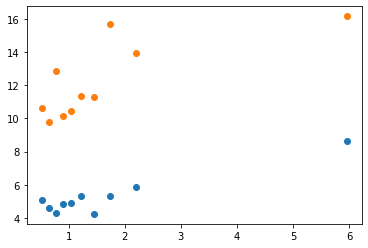

In [100]:
qs = []
drls = []
psses = []
qts = [0.1*i for i in range(1,11)]
# for q in np.linspace(0.1,0.9,100):
for q in qts:
    fea_small_data = data[data.iloc[:,-3]<=data.iloc[:,-3].quantile(q)]
    ind = np.logical_and(data.iloc[:,-3]>data.iloc[:,-3].quantile(q-0.1),
        data.iloc[:,-3]<=data.iloc[:,-3].quantile(q))
    fea_big_data = data[ind]

    small_win = (fea_small_data[['drl','pss']]==0).sum()/len(fea_small_data)
    big_win = (fea_big_data[['drl','pss']]==0).sum()/len(fea_big_data)

    tmp = fea_small_data[['drl','pss']]
    small_lost = tmp[tmp>0].mean()
    tmp = fea_big_data[['drl','pss']]
    big_lost = tmp[tmp>0].mean()

    drls.append(big_lost.drl)
    psses.append(big_lost.pss)
    qs.append(data.iloc[:,-3].quantile(q))

    out1 = pd.concat((small_lost, big_lost), axis=1).rename(
        index={'drl':'智能体赔率','pss':'挂单赔率'},columns={0:'小',1:'大'})
    out2 = pd.concat((small_win, big_win), axis=1).rename(
        index={'drl':'智能体胜率','pss':'挂单胜率'},columns={0:'小',1:'大'})
    # pd.concat((out, small_win, big_win), axis=1)
plt.scatter(qs, drls)
plt.scatter(qs, psses)
# plt.scatter(qs, np.array(psses)-np.array(drls))

In [111]:
fea_small_data = data[data.iloc[:,-1]<=data.iloc[:,-1].quantile(0.5)]
fea_big_data = data[data.iloc[:,-1]>data.iloc[:,-1].quantile(0.5)]

small_win = (fea_small_data[['drl','pss']]==0).sum()/len(fea_small_data)
big_win = (fea_big_data[['drl','pss']]==0).sum()/len(fea_big_data)

tmp = fea_small_data[['drl','pss']]
small_lost = tmp[tmp>0].mean()
tmp = fea_big_data[['drl','pss']]
big_lost = tmp[tmp>0].mean()

drls.append(big_lost.drl)
psses.append(big_lost.pss)
qs.append(data.iloc[:,-3].quantile(q))

out1 = pd.concat((small_lost, big_lost), axis=1).rename(
    index={'drl':'智能体赔率','pss':'挂单赔率'},columns={0:'小',1:'大'})
out2 = pd.concat((small_win, big_win), axis=1).rename(
    index={'drl':'智能体胜率','pss':'挂单胜率'},columns={0:'小',1:'大'})

In [112]:

from statsmodels.stats.weightstats import ztest
tmp = fea_small_data[['drl','pss']]
small_lost = tmp[tmp>0]
tmp = fea_big_data[['drl','pss']]
big_lost = tmp[tmp>0]
print('挂单赔率差距p-value:',ztest(small_lost.pss.dropna(), big_lost.pss.dropna())[1])
print('智能体赔率差距p-value:',ztest(small_lost.drl.dropna(), big_lost.drl.dropna())[1])
small_win = fea_small_data[['drl','pss']]==0
big_win = fea_big_data[['drl','pss']]==0
print('挂单胜率差距p-value:',ztest(small_win.pss, big_win.pss)[1])
print('智能体胜率差距p-value:',ztest(small_win.drl, big_win.drl)[1])
pd.concat((out1, out2)).T

挂单赔率差距p-value: 2.9421911220183614e-09
智能体赔率差距p-value: 0.47645967943455947
挂单胜率差距p-value: 0.34376800729290924
智能体胜率差距p-value: 0.017815419122307656


,智能体赔率,挂单赔率,智能体胜率,挂单胜率
小,5.121507,10.273418,0.901942,0.952089
大,5.290805,13.984076,0.890864,0.955145


In [54]:
from statsmodels.stats.weightstats import ztest
tmp = fea_small_data[['drl','pss']]
small_lost = tmp[tmp>0]
tmp = fea_big_data[['drl','pss']]
big_lost = tmp[tmp>0]
print(ztest(small_lost.pss.dropna(), big_lost.pss.dropna()))
print(ztest(small_lost.drl.dropna(), big_lost.drl.dropna()))
len(big_lost.drl.dropna()), len(small_lost.drl.dropna())

(-4.32061518524014, 1.555948102719042e-05)
(-4.330168898668305, 1.4899501830863425e-05)


(762, 931)

In [6]:
def getStdFactor(inData, cuts=5, ifqcut=True):
    Data = inData.dropna()

    per95 = Data.quantile(0.975, interpolation='nearest')
    per05 = Data.quantile(0.025, interpolation='nearest')
    Data.loc[Data > per95] = per95
    Data.loc[Data < per05] = per05
    eps = 0.001
    ibins = np.linspace(per05-eps, per95+eps, cuts+1, endpoint=True)
    ilabels = range(1, cuts+1, 1)
    
    try:
        tmpfactor = pd.qcut(Data, q=cuts, duplicates='drop')
    except:
        return pd.Series(index=inData.index)
    binsnum = len(tmpfactor.cat.categories)
    ilabels = ilabels[:binsnum]

    if ifqcut:
        factor,ibins = pd.qcut(Data, q=cuts, labels=ilabels, duplicates='drop', retbins=True)
    else:
        factor = pd.cut(Data, bins=ibins, labels=ilabels)

    factor = factor.astype(float)
    factor = factor.reindex(inData.index)

    return factor

In [1]:
from cal_feature import *
obj='rb'
log_path='/Data/database/logs_thunder'
tick_path='/Data/database/data_zltick/'
dat = '20220321'
tick_path = os.path.join(tick_path, obj)
log_path = os.path.join(log_path, dat)
tick_data, contract = preprocess(tick_path, dat+'.csv')
tick_data = tick_data.reset_index()#[['datetime','orig_v']]
tick_data['ticktime'] = tick_data.datetime.astype('str').apply(lambda x:x.split(' ')[1])
tick_data['tickdate'] = tick_data.datetime.dt.date
last_date = tick_data.tickdate.iloc[0]

last_data, _ = preprocess(tick_path, last_date.strftime("%Y%m%d")+'.csv')
last_data = last_data.reset_index()
last_data['ticktime'] = last_data.datetime.astype('str').apply(lambda x:x.split(' ')[1])
last_data['tickdate'] = last_data.datetime.dt.date
all_tick_len = len(last_data)

tick_data = pd.concat([last_data, tick_data], axis=0)
ll = len(tick_data)
a, acc = SingleDayHDAll('acc_sub.txt', log_path, dat) 

jud = (a.ticker==obj)&(a.symbol==contract)&\
        (((a.fx>0)&(a.odprice==a.bidprice)) |\
        ((a.fx<0)&(a.odprice==a.askprice))
        )
a = a[jud][['symbol', 'agg_cost', 'pss_cost', 'ticktime', 'fx', 'filled_value', 'filled_lots',
    'filled_seconds', 'filled_date', 'pv', 'filled_price',]]
a['ticktime'] = a.ticktime.apply(lambda x:x+'00' if x.split('.')[1]=='0' else x)

feas = []
times = []


for _,trade in a.iterrows():
    
    if trade.isnull().any():
        continue

    tim = trade['ticktime']
    s, ms = tim.split('.')
    tims = s+'.000' if int(ms)<500 else s+'.500'
    tim = pd.to_datetime(trade.filled_date+' '+tims)

    if obj in ['m'] and int(tims.split(':')[0])>=21:
        # print('tim', tim, last_date)
        tim = pd.to_datetime(str(last_date)+' '+tims)
        # print('tim', tim, last_date)
    # print(type(day))
    # print(trade)
    # print(tick_data[tick_data.ticktime==tim])
    # assert 
    ord = tick_data.datetime.searchsorted(tim, side='right')-1
    # print(dat)
    # print(tim)
    # print(trade)
    # print(tick_data.iloc[ord-3:ord+3])
    # print('')
    # ord = tick_data[tick_data.ticktime==tim].index[0]
    # print(ord, all_tick_len)
    if ord-100+1<all_tick_len:
        continue
    if ord+120>=ll:
        continue
    # print(dat, tim)
    data = volatility(tick_data, ord, 30, 600)
    break
data


1134    NaN
1164   -1.5
1194    0.0
1224   -2.0
1254   -2.0
1284    1.0
1314   -1.0
1344    1.0
1374   -1.0
1404    1.0
1434   -1.0
1464    3.0
1494    1.0
1524    1.0
1554    0.0
1584   -3.0
1614    0.0
1644    1.0
1674   -1.0
1704    0.0
Name: midprice, dtype: float32